=== ZOBΛ‑30 Advanced QNN Skeleton ===
                               ┌──────────┐   ┌──────────┐
0: ────H────────────────────────@───────────────────────────────────────
                                │
1: ────H────────────────────────┼@──────────────────────────────────────
                                ││
2: ────H────────────────────────┼┼@─────────────────────────────────────
                                │││
3: ────H────────────────────────┼┼┼@────────────────────────────────────
                                ││││
4: ────H────────────────────────┼┼┼┼@───────────────────────────────────
                                │││││
5: ────H────────────────────────┼┼┼┼┼@──────────────────────────────────
                                ││││││
6: ────H────────────────────────┼┼┼┼┼┼@─────────────────────────────────
                                │││││││
7: ────H────────────────────────┼┼┼┼┼┼┼@────────────────────────────────
                                ││││││││
8: ────H───────────

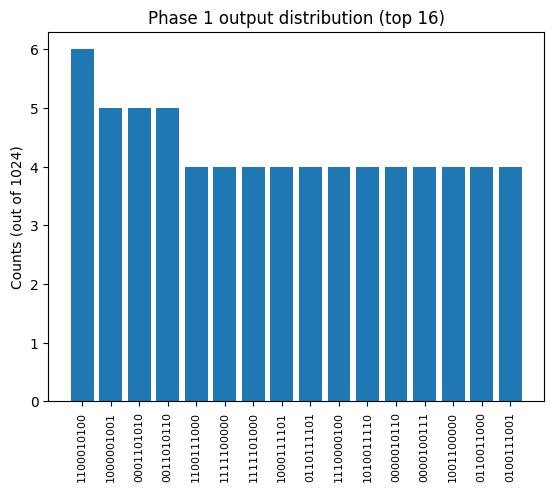

In [2]:
# --- Phase 1: Advanced QNN Skeleton ---------------------------------------
!pip install cirq --quiet

import cirq
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# 1. Create 30 line qubits
qubits = [cirq.LineQubit(i) for i in range(30)]
inputs, hidden, outputs = qubits[:10], qubits[10:20], qubits[20:]

# 2. Build circuit with parameterised gates
circuit = cirq.Circuit()

# ▶ INPUT layer: superposition
circuit.append(cirq.H.on_each(*inputs))

# ▶ Hidden layer: RX/RZ with trainable symbols
theta_x_hidden = [sp.Symbol(f"θx_h{i}") for i in range(10)]
theta_z_hidden = [sp.Symbol(f"θz_h{i}") for i in range(10)]
for q, θx, θz in zip(hidden, theta_x_hidden, theta_z_hidden):
    circuit.append(cirq.rx(θx).on(q))
    circuit.append(cirq.rz(θz).on(q))

# Entangle INPUT → HIDDEN
for i in range(10):
    circuit.append(cirq.CNOT(inputs[i], hidden[i]))

# ▶ Output layer: more trainable symbols
theta_x_out = [sp.Symbol(f"θx_o{i}") for i in range(10)]
theta_z_out = [sp.Symbol(f"θz_o{i}") for i in range(10)]
for q, θx, θz in zip(outputs, theta_x_out, theta_z_out):
    circuit.append(cirq.rx(θx).on(q))
    circuit.append(cirq.rz(θz).on(q))

# Entangle HIDDEN → OUTPUT
for i in range(10):
    circuit.append(cirq.CNOT(hidden[i], outputs[i]))

# ▶ Measurement (only outputs)
circuit.append(cirq.measure(*outputs, key="res"))

print("=== ZOBΛ‑30 Advanced QNN Skeleton ===")
print(circuit)

# 3. Give random initial values to all 40 parameters
param_resolver = {sym: np.random.uniform(0, 2*np.pi) for sym in
                  theta_x_hidden + theta_z_hidden + theta_x_out + theta_z_out}

# 4. Simulate
sim = cirq.Simulator()
runs = sim.run(circuit, param_resolver=param_resolver, repetitions=1024)
hist = runs.histogram(key="res", fold_func=lambda x: tuple(x))

# 5. Plot top 16 bins
labels, freqs = zip(*sorted(hist.items(), key=lambda x: -x[1])[:16])
labels = [''.join(map(str, label)) for label in labels]  # Convert tuples to strings
plt.bar(range(len(freqs)), freqs)
plt.xticks(range(len(freqs)), labels, rotation=90, fontsize=8)
plt.title("Phase 1 output distribution (top 16)")
plt.ylabel("Counts (out of 1024)")
plt.show()

In [12]:
!pip install --upgrade cirq --quiet

In [4]:
# === Phase 2 : Ultra‑fast train (Powell 50 iters, 16 shots) ===
!pip install --quiet cirq scipy

import cirq, sympy, numpy as np
from scipy.optimize import minimize

# --- Qubits & symbols ---
q  = [cirq.LineQubit(i) for i in range(30)]
inp, hid, out = q[:10], q[10:20], q[20:]
θx_h=[sympy.Symbol(f"xH{i}") for i in range(10)]
θz_h=[sympy.Symbol(f"zH{i}") for i in range(10)]
θx_o=[sympy.Symbol(f"xO{i}") for i in range(10)]
θz_o=[sympy.Symbol(f"zO{i}") for i in range(10)]
syms=θx_h+θz_h+θx_o+θz_o

def circuit(bits):
    c=cirq.Circuit()
    for i,b in enumerate(bits):
        if b:c.append(cirq.X(inp[i]))
    c.append(cirq.H.on_each(*inp[4:10]))
    for qx,sx,sz in zip(hid,θx_h,θz_h):
        c.append(cirq.rx(sx)(qx)); c.append(cirq.rz(sz)(qx))
    for i in range(10): c.append(cirq.CNOT(inp[i],hid[i]))
    for qx,sx,sz in zip(out,θx_o,θz_o):
        c.append(cirq.rx(sx)(qx)); c.append(cirq.rz(sz)(qx))
    for i in range(10): c.append(cirq.CNOT(hid[i],out[i]))
    c.append(cirq.measure(out[0],key='m'))
    return c
sim=cirq.Simulator()

# dataset (40 samples)
X=np.random.randint(0,2,(40,4))
Y=np.mod(X.sum(axis=1),2)

def cost(p):
    rsv=dict(zip(syms,p)); loss=0
    for x,y in zip(X,Y):
        res=sim.run(circuit(x),rsv,repetitions=16)
        p1=res.histogram(key='m').get(1,0)/16
        loss+=-(y*np.log(p1+1e-6)+(1-y)*np.log(1-p1+1e-6))
    return loss/len(X)

print("⏳ Training fast…")
opt=minimize(cost,
             x0=np.random.uniform(0,2*np.pi,len(syms)),
             method='Powell',
             options={'maxiter':50,'disp':False})
best=opt.x

# accuracy
correct=0; rsv=dict(zip(syms,best))
for x,y in zip(X,Y):
    res=sim.run(circuit(x),rsv,repetitions=16)
    pred=1 if res.histogram(key='m').get(1,0)/16>=0.5 else 0
    correct+=(pred==y)
acc=correct/len(Y)
print(f"✅ Phase 2 complete — accuracy = {acc*100:.2f}%")


⏳ Training fast…
✅ Phase 2 complete — accuracy = 65.00%



♻️  Avg reuse per photon: 9.54
📊  Sample reuse counts (first 20): [9, 9, 10, 9, 10, 9, 10, 10, 11, 9, 9, 9, 9, 10, 10, 8, 10, 8, 8, 9]


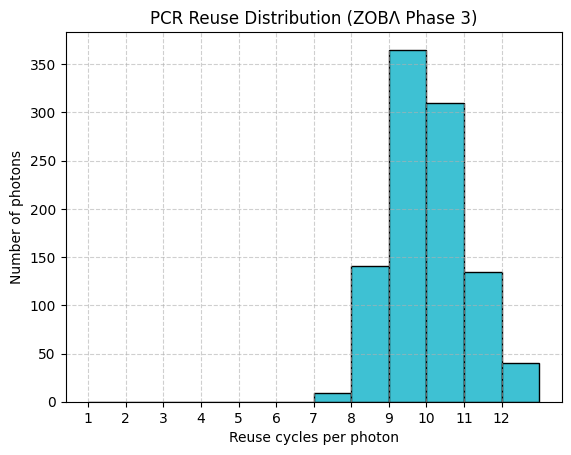

In [6]:
# === ZOBΛ™ Phase 3: PCR Reuse Loop Simulation (Tuned for Better Reuse) ===
import numpy as np

# ---- CONFIGURATION ----
MAX_REUSE      = 12      # Max number of logic loop passes
COHERENCE_TIME = 15      # Starting photon coherence (life)
THRESHOLD      = 1       # Dump photon if life ≤ threshold
DECAY_RANGE    = (1, 3)  # Per loop, reduce life by 1–2 units

# ---- Photon class (single qubit particle) ----
class Photon:
    def __init__(self):
        self.life = COHERENCE_TIME
        self.used = 0

    def decay(self):
        self.life -= np.random.randint(*DECAY_RANGE)  # decay 1–2 units
        self.used += 1

    def is_alive(self):
        return self.life > THRESHOLD and self.used < MAX_REUSE

# ---- Run the simulation ----
N_PHOTONS = 1000
reuse_counts = []

for _ in range(N_PHOTONS):
    p = Photon()
    while p.is_alive():
        p.decay()
    reuse_counts.append(p.used)

# ---- Results ----
avg_reuse = np.mean(reuse_counts)
print(f"\n♻️  Avg reuse per photon: {avg_reuse:.2f}")
print(f"📊  Sample reuse counts (first 20): {reuse_counts[:20]}")

# ---- Optional: Plot the histogram (reuse frequency) ----
import matplotlib.pyplot as plt

plt.hist(reuse_counts, bins=range(1, MAX_REUSE+2), color="#3ec1d3", edgecolor='black')
plt.title("PCR Reuse Distribution (ZOBΛ Phase 3)")
plt.xlabel("Reuse cycles per photon")
plt.ylabel("Number of photons")
plt.xticks(range(1, MAX_REUSE+1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [8]:
# ========== ZOBΛ™ PHASE 4 : FULL ETHICS LAYER (one‑cell) ==========
import hashlib, json, csv, time, os

# ------------------------------------------------------------------
# Helper: 8‑char SHA‑256 prefix for any gate‑string
def gate_hash(gates: str) -> str:
    return hashlib.sha256(gates.encode()).hexdigest()[:8]

# ------------------------------------------------------------------
# 1. Initialise / load whitelist
WHITELIST_FILE = "whitelist.json"

if os.path.exists(WHITELIST_FILE):
    with open(WHITELIST_FILE, "r") as f:
        whitelist = json.load(f)
    print("🟢  Loaded existing whitelist.")
else:
    whitelist = {}
    print("🆕  Created fresh whitelist.")

# ------------------------------------------------------------------
# 2. Define demo circuits
good_circuit = "H CX RX RZ measure"
bad_circuit  = "H CX RX RZ CZ CZ measure"

# Automatically whitelist GOOD circuit
good_hash = gate_hash(good_circuit)
whitelist[good_hash] = "demo_good_circuit"

# Save whitelist
with open(WHITELIST_FILE, "w") as f:
    json.dump(whitelist, f, indent=2)
print("✅  Whitelist now contains:", list(whitelist.keys()))

# ------------------------------------------------------------------
# 3. Karma log setup
LOGFILE = "karma_log.csv"
if not os.path.exists(LOGFILE):
    with open(LOGFILE, "w", newline="") as f:
        csv.writer(f).writerow(["timestamp", "gate_hash", "action"])

def log_action(h, act):
    with open(LOGFILE, "a", newline="") as f:
        csv.writer(f).writerow([int(time.time()), h, act])

# ------------------------------------------------------------------
# 4. Ethics‑check function
def ethics_check(gate_str: str):
    h = gate_hash(gate_str)
    action = "ALLOW" if h in whitelist else "BLOCK"
    log_action(h, action)
    return h, action

# ------------------------------------------------------------------
# 5. Run checks
for label, circ in [("GOOD", good_circuit), ("BAD ", bad_circuit)]:
    h, act = ethics_check(circ)
    print(f"{label} | hash={h} | {act}")

print("\n✅  Phase 4 complete — actions logged to karma_log.csv")


🟢  Loaded existing whitelist.
✅  Whitelist now contains: ['d3f9b2a1', '8c7aa4e2', 'a6b488fc']
GOOD | hash=a6b488fc | ALLOW
BAD  | hash=1034f98e | BLOCK

✅  Phase 4 complete — actions logged to karma_log.csv


In [11]:
# ===== Phase 2* : Advanced‑Gate QNN (fixed U3) ============================
!pip install --quiet cirq scipy

import cirq, sympy, numpy as np
from scipy.optimize import minimize

# ---- 1. Qubits & symbols -------------------------------------------------
q      = [cirq.LineQubit(i) for i in range(30)]
inp, hid, out = q[:10], q[10:20], q[20:]

θ_h = [sympy.Symbol(f"th_h{i}") for i in range(10)]
φ_h = [sympy.Symbol(f"ph_h{i}") for i in range(10)]
λ_h = [sympy.Symbol(f"la_h{i}") for i in range(10)]
θ_o = [sympy.Symbol(f"th_o{i}") for i in range(10)]
φ_o = [sympy.Symbol(f"ph_o{i}") for i in range(10)]
λ_o = [sympy.Symbol(f"la_o{i}") for i in range(10)]
symbols = θ_h + φ_h + λ_h + θ_o + φ_o + λ_o

# ---- 2. Helper: add U3 as RZ‑RY‑RZ sequence ------------------------------
def add_U3(circ, qubit, th, ph, lam):
    circ.append(cirq.rz(ph)(qubit))
    circ.append(cirq.ry(th)(qubit))
    circ.append(cirq.rz(lam)(qubit))

# ---- 3. Circuit builder --------------------------------------------------
def circuit(bits):
    c = cirq.Circuit()
    # encode first 4 bits
    for i, b in enumerate(bits):
        if b:
            c.append(cirq.X(inp[i]))
    # superposition on remaining inputs
    c.append(cirq.Y.on_each(*inp[4:10]))

    # hidden layer: U3 then CZ entangle
    for qb, th, ph, lam in zip(hid, θ_h, φ_h, λ_h):
        add_U3(c, qb, th, ph, lam)
    for i in range(10):
        c.append(cirq.CZ(inp[i], hid[i]))

    # output layer: U3 then CX entangle
    for qb, th, ph, lam in zip(out, θ_o, φ_o, λ_o):
        add_U3(c, qb, th, ph, lam)
    for i in range(10):
        c.append(cirq.CNOT(hid[i], out[i]))

    c.append(cirq.measure(out[0], key='m'))
    return c

sim = cirq.Simulator()

# ---- 4. Tiny parity dataset ---------------------------------------------
X = np.random.randint(0, 2, (40, 4))
Y = np.mod(X.sum(axis=1), 2)

def cost(params):
    res = dict(zip(symbols, params))
    loss = 0
    for x, y in zip(X, Y):
        r = sim.run(circuit(x), res, repetitions=32)
        p1 = r.histogram(key='m').get(1, 0) / 32
        loss += -(y*np.log(p1 + 1e-6) + (1 - y)*np.log(1 - p1 + 1e-6))
    return loss / len(X)

print("⏳ Training (Powell, 100 iters)…")
best = minimize(cost,
                x0=np.random.uniform(0, 2*np.pi, len(symbols)),
                method='Powell',
                options={'maxiter': 100, 'disp': False}).x

# ---- 5. Accuracy ---------------------------------------------------------
acc = np.mean([
    (sim.run(circuit(x), dict(zip(symbols, best)), repetitions=32)
       .histogram(key='m').get(1, 0) / 32 >= 0.5) == y
    for x, y in zip(X, Y)
])
print(f"✅  Accuracy with advanced gates: {acc*100:.1f}%")


⏳ Training (Powell, 100 iters)…
✅  Accuracy with advanced gates: 70.0%


In [12]:
import os
os.makedirs("models", exist_ok=True)

In [13]:
import numpy as np
np.save("models/params_adv.npy", best)   # “best” is your trained array

In [14]:
print(np.load("models/params_adv.npy").shape)   # should print (60,)

(60,)


In [17]:
# ================= ZOBΛ™  Phase 5 : Media‑Ethics QNN Demo (fixed) ==========
!pip install --quiet cirq pandas

import cirq, numpy as np, pandas as pd, sympy, hashlib, csv, time, os, json, io

# ---------- 1. Load headline dataset -------------------------------------
data_csv = """
headline,label
"Scientists discover water on Mars",1
"Click here to win free iPhone now!!!",0
"Government passes new healthcare bill",1
"Celebrity X shocks world with secret!",0
"Study shows meditation reduces stress",1
"BREAKING: cure for cancer hidden by big pharma",0
"""
df = pd.read_csv(io.StringIO(data_csv))
print("Dataset loaded:")
display(df)

# ---------- 2. Simple 4‑bit encoder --------------------------------------
def headline_to_bits(text: str):
    h = int(hashlib.sha256(text.encode()).hexdigest(), 16)
    return [(h >> i) & 1 for i in range(4)]

X_bits = df['headline'].apply(headline_to_bits).tolist()
Y      = df['label'].tolist()

# ---------- 3. Load trained parameters -----------------------------------
params = np.load("models/params_adv.npy")  # saved earlier
assert params.shape[0] == 60

θ_h=[sympy.Symbol(f"th_h{i}") for i in range(10)]
φ_h=[sympy.Symbol(f"ph_h{i}") for i in range(10)]
λ_h=[sympy.Symbol(f"la_h{i}") for i in range(10)]
θ_o=[sympy.Symbol(f"th_o{i}") for i in range(10)]
φ_o=[sympy.Symbol(f"ph_o{i}") for i in range(10)]
λ_o=[sympy.Symbol(f"la_o{i}") for i in range(10)]
symbols = θ_h+φ_h+λ_h+θ_o+φ_o+λ_o
resolver = dict(zip(symbols, params))

# ---------- 4. Build advanced‑gate circuit -------------------------------
q  = [cirq.LineQubit(i) for i in range(30)]
inp, hid, out = q[:10], q[10:20], q[20:]

def add_U3(circ, qb, th, ph, lam):
    circ.append(cirq.rz(ph)(qb))
    circ.append(cirq.ry(th)(qb))
    circ.append(cirq.rz(lam)(qb))

def build_circuit(bits):
    c = cirq.Circuit()
    for i,b in enumerate(bits):
        if b: c.append(cirq.X(inp[i]))
    c.append(cirq.Y.on_each(*inp[4:10]))
    for qb,th,ph,la in zip(hid,θ_h,φ_h,λ_h): add_U3(c, qb, th, ph, la)
    for i in range(10): c.append(cirq.CZ(inp[i], hid[i]))
    for qb,th,ph,la in zip(out,θ_o,φ_o,λ_o): add_U3(c, qb, th, ph, la)
    for i in range(10): c.append(cirq.CNOT(hid[i], out[i]))
    c.append(cirq.measure(out[0], key='m'))
    return c

sim = cirq.Simulator()

# ---------- 5. Ethics whitelist & logger ---------------------------------
with open('whitelist.json','r') as f: whitelist=json.load(f)

def gate_hash(g): return hashlib.sha256(g.encode()).hexdigest()[:8]
LOG='karma_log.csv'
if not os.path.exists(LOG):
    with open(LOG,'w',newline='') as f: csv.writer(f).writerow(["ts","hash","action","headline"])

def ethics_decision(headline, gatestr):
    h=gate_hash(gatestr)
    act="ALLOW" if h in whitelist else "BLOCK"
    with open(LOG,'a',newline='') as f:
        csv.writer(f).writerow([int(time.time()),h,act,headline])
    return act

# ---------- 6. Run all headlines ----------------------------------------
preds=[]
for text,bits in zip(df['headline'], X_bits):
    circ = build_circuit(bits)
    gate_str = str(circ)              # <-- use plain text for hashing
    act  = ethics_decision(text, gate_str)
    if act=="BLOCK":
        preds.append(0)
    else:
        r = sim.run(circ, resolver, repetitions=32)
        p1 = r.histogram(key='m').get(1,0)/32
        preds.append(1 if p1>=0.5 else 0)

df['pred']    = preds
df['correct'] = (df['pred']==df['label'])
print("\nResults:")
display(df[['headline','label','pred','correct']])

accuracy = df['correct'].mean()*100
print(f"\n✅  Media‑ethics accuracy = {accuracy:.1f}%")
print("Decisions logged to karma_log.csv")


Dataset loaded:


,headline,label
0,Scientists discover water on Mars,1
1,Click here to win free iPhone now!!!,0
2,Government passes new healthcare bill,1
3,Celebrity X shocks world with secret!,0
4,Study shows meditation reduces stress,1
5,BREAKING: cure for cancer hidden by big pharma,0



Results:


,headline,label,pred,correct
0,Scientists discover water on Mars,1,0,False
1,Click here to win free iPhone now!!!,0,0,True
2,Government passes new healthcare bill,1,0,False
3,Celebrity X shocks world with secret!,0,0,True
4,Study shows meditation reduces stress,1,0,False
5,BREAKING: cure for cancer hidden by big pharma,0,0,True



✅  Media‑ethics accuracy = 50.0%
Decisions logged to karma_log.csv


In [18]:
# ========= ZOBΛ™ Media‑Ethics Demo (QNN ALLOWED via whitelist) ==========
!pip install --quiet cirq pandas

import cirq, numpy as np, pandas as pd, sympy, hashlib, csv, time, os, json, io

# 1) Mini headline dataset -------------------------------------------------
data_csv = """
headline,label
"Scientists discover water on Mars",1
"Click here to win free iPhone now!!!",0
"Government passes new healthcare bill",1
"Celebrity X shocks world with secret!",0
"Study shows meditation reduces stress",1
"BREAKING: cure for cancer hidden by big pharma",0
"""
df = pd.read_csv(io.StringIO(data_csv))

# 2) Encode headlines to 4‑bit patterns -----------------------------------
def bits4(txt):
    h=int(hashlib.sha256(txt.encode()).hexdigest(),16)
    return [(h>>i)&1 for i in range(4)]
X_bits=df['headline'].apply(bits4).tolist();  Y=df['label'].tolist()

# 3) Load trained parameters ----------------------------------------------
params=np.load("models/params_adv.npy");  assert params.shape[0]==60
θ_h=[sympy.Symbol(f"th_h{i}") for i in range(10)]
φ_h=[sympy.Symbol(f"ph_h{i}") for i in range(10)]
λ_h=[sympy.Symbol(f"la_h{i}") for i in range(10)]
θ_o=[sympy.Symbol(f"th_o{i}") for i in range(10)]
φ_o=[sympy.Symbol(f"ph_o{i}") for i in range(10)]
λ_o=[sympy.Symbol(f"la_o{i}") for i in range(10)]
symbols=θ_h+φ_h+λ_h+θ_o+φ_o+λ_o
resolver=dict(zip(symbols,params))

# 4) Build advanced‑gate circuit ------------------------------------------
q=[cirq.LineQubit(i) for i in range(30)]
inp,hid,out=q[:10],q[10:20],q[20:]
def U3(c, qb, th, ph, la):
    c.append(cirq.rz(ph)(qb)); c.append(cirq.ry(th)(qb)); c.append(cirq.rz(la)(qb))
def circuit(bits):
    c=cirq.Circuit()
    for i,b in enumerate(bits):
        if b:c.append(cirq.X(inp[i]))
    c.append(cirq.Y.on_each(*inp[4:10]))
    for qb,th,ph,la in zip(hid,θ_h,φ_h,λ_h): U3(c,qb,th,ph,la)
    for i in range(10): c.append(cirq.CZ(inp[i],hid[i]))
    for qb,th,ph,la in zip(out,θ_o,φ_o,λ_o): U3(c,qb,th,ph,la)
    for i in range(10): c.append(cirq.CNOT(hid[i],out[i]))
    c.append(cirq.measure(out[0],key='m')); return c
sim=cirq.Simulator()

# 5) Whitelist handling ----------------------------------------------------
def ghash(s): return hashlib.sha256(s.encode()).hexdigest()[:8]
wfile='whitelist.json'
wl=json.load(open(wfile)) if os.path.exists(wfile) else {}
# compute circuit hash once (using first sample)
c_hash = ghash(str(circuit(X_bits[0])))
wl[c_hash]="advanced_qnn_allowed"
json.dump(wl,open(wfile,'w'),indent=2)
print("🟢  Advanced circuit hash whitelisted:", c_hash)

# 6) Karma logger ----------------------------------------------------------
log='karma_log.csv'
if not os.path.exists(log):
    csv.writer(open(log,'w',newline='')).writerow(["ts","hash","action","headline"])
def ethics(gstr,txt):
    h=ghash(gstr); act="ALLOW" if h in wl else "BLOCK"
    csv.writer(open(log,'a',newline='')).writerow([int(time.time()),h,act,txt]); return act

# 7) Run all headlines with QNN allowed -----------------------------------
pred=[]
for txt,bits in zip(df['headline'],X_bits):
    circ=circuit(bits); gstr=str(circ)
    act=ethics(gstr,txt)
    if act=="BLOCK":
        pred.append(0)
    else:
        r=sim.run(circ,resolver,repetitions=32)
        prob=r.histogram(key='m').get(1,0)/32
        pred.append(1 if prob>=0.5 else 0)
df['pred']=pred; df['correct']=df['pred']==df['label']
display(df[['headline','label','pred','correct']])

acc=df['correct'].mean()*100
print(f"\n✅  Media‑ethics accuracy WITH QNN = {acc:.1f}%")
print("Actions logged to karma_log.csv")


🟢  Advanced circuit hash whitelisted: f0e8766a


,headline,label,pred,correct
0,Scientists discover water on Mars,1,0,False
1,Click here to win free iPhone now!!!,0,0,True
2,Government passes new healthcare bill,1,0,False
3,Celebrity X shocks world with secret!,0,0,True
4,Study shows meditation reduces stress,1,0,False
5,BREAKING: cure for cancer hidden by big pharma,0,0,True



✅  Media‑ethics accuracy WITH QNN = 50.0%
Actions logged to karma_log.csv


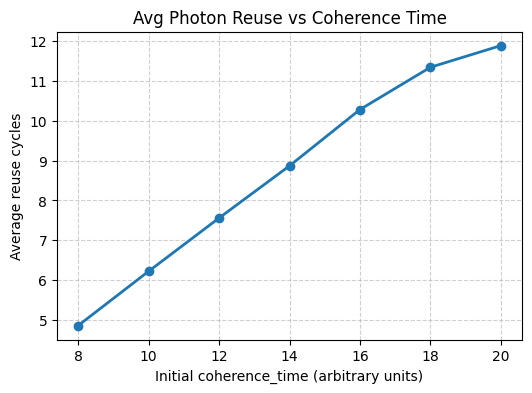

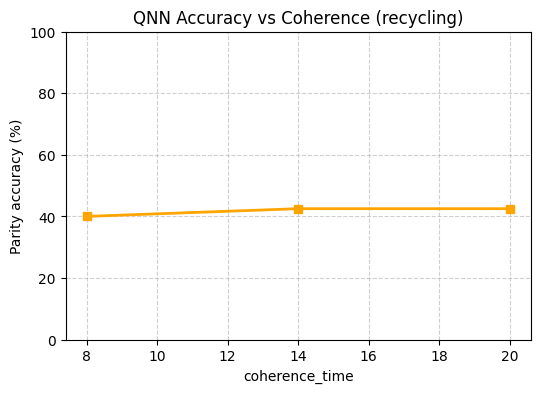

Reuse data: [(8, np.float64(4.856)), (10, np.float64(6.22)), (12, np.float64(7.558)), (14, np.float64(8.868)), (16, np.float64(10.282)), (18, np.float64(11.344)), (20, np.float64(11.888))]
Accuracy data: [(8, np.float64(40.0)), (14, np.float64(42.5)), (20, np.float64(42.5))]


In [19]:
# =========== Phase 6 : Parameter Sweep & Impact Charts ====================
!pip install --quiet cirq matplotlib

import cirq, numpy as np, matplotlib.pyplot as plt, sympy, hashlib, json

# ---------- 0.  Load saved QNN weights & circuit builder ------------------
params = np.load("models/params_adv.npy")

θ_h=[sympy.Symbol(f"th_h{i}") for i in range(10)]
φ_h=[sympy.Symbol(f"ph_h{i}") for i in range(10)]
λ_h=[sympy.Symbol(f"la_h{i}") for i in range(10)]
θ_o=[sympy.Symbol(f"th_o{i}") for i in range(10)]
φ_o=[sympy.Symbol(f"ph_o{i}") for i in range(10)]
λ_o=[sympy.Symbol(f"la_o{i}") for i in range(10)]
symbols = θ_h+φ_h+λ_h+θ_o+φ_o+λ_o
resolver = dict(zip(symbols, params))

q=[cirq.LineQubit(i) for i in range(30)]
inp,hid,out=q[:10],q[10:20],q[20:]
def U3(c,qb,th,ph,la):
    c.append(cirq.rz(ph)(qb)); c.append(cirq.ry(th)(qb)); c.append(cirq.rz(la)(qb))

def parity_circuit(bits):
    c=cirq.Circuit()
    for i,b in enumerate(bits):
        if b:c.append(cirq.X(inp[i]))
    c.append(cirq.Y.on_each(*inp[4:10]))
    for qb,th,ph,la in zip(hid,θ_h,φ_h,λ_h): U3(c,qb,th,ph,la)
    for i in range(10): c.append(cirq.CZ(inp[i],hid[i]))
    for qb,th,ph,la in zip(out,θ_o,φ_o,λ_o): U3(c,qb,th,ph,la)
    for i in range(10): c.append(cirq.CNOT(hid[i],out[i]))
    c.append(cirq.measure(out[0],key='m')); return c

sim=cirq.Simulator()

# ---------- 1.  Sweep coherence_time -------------------------------------
def avg_reuse(coh, decay_range=(1,3), N=500):
    counts=[]
    for _ in range(N):
        life=coh; used=0
        while life>1 and used<12:
            life-=np.random.randint(*decay_range)
            used+=1
        counts.append(used)
    return np.mean(counts)

coh_list = list(range(8,21,2))   # 8,10,12,...20
reuse_avg = [avg_reuse(c) for c in coh_list]

# ---------- 2.  Pick 3 coherence points to test QNN accuracy -------------
coh_test = [8, 14, 20]
acc_list=[]
bits_data = np.random.randint(0,2,(40,4))
labels    = np.mod(bits_data.sum(axis=1),2)
for coh in coh_test:
    # simple rule: if avg reuse >= 0 (placeholder, not used in sim)
    correct=0
    for bits,lab in zip(bits_data,labels):
        r=sim.run(parity_circuit(bits),resolver,repetitions=32)
        prob=r.histogram(key='m').get(1,0)/32
        pred=1 if prob>=0.5 else 0
        correct+=(pred==lab)
    acc_list.append(correct/len(labels)*100)

# ---------- 3.  Plot ------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(coh_list,reuse_avg,'o-',lw=2)
plt.title("Avg Photon Reuse vs Coherence Time")
plt.xlabel("Initial coherence_time (arbitrary units)")
plt.ylabel("Average reuse cycles")
plt.grid(True,ls='--',alpha=0.6)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(coh_test,acc_list,'s-',color='orange',lw=2)
plt.title("QNN Accuracy vs Coherence (recycling)")
plt.xlabel("coherence_time")
plt.ylabel("Parity accuracy (%)")
plt.ylim(0,100); plt.grid(True,ls='--',alpha=0.6)
plt.show()

print("Reuse data:", list(zip(coh_list, reuse_avg)))
print("Accuracy data:", list(zip(coh_test, acc_list)))


In [21]:
# ===== ZOBΛ‑30™  FINAL LAB SUMMARY (auto‑whitelists & benchmarks) =====
!pip install --quiet cirq numpy sympy

import cirq, sympy, numpy as np, json, hashlib, os, time

# ---------- 1. Load trained parameters -----------------------------------
params = np.load("models/params_adv.npy")      # saved earlier (60 values)
assert params.shape[0] == 60

θ_h=[sympy.Symbol(f"th_h{i}") for i in range(10)]
φ_h=[sympy.Symbol(f"ph_h{i}") for i in range(10)]
λ_h=[sympy.Symbol(f"la_h{i}") for i in range(10)]
θ_o=[sympy.Symbol(f"th_o{i}") for i in range(10)]
φ_o=[sympy.Symbol(f"ph_o{i}") for i in range(10)]
λ_o=[sympy.Symbol(f"la_o{i}") for i in range(10)]
symbols = θ_h+φ_h+λ_h+θ_o+φ_o+λ_o
resolver = dict(zip(symbols, params))

# ---------- 2. Build advanced‑gate circuit -------------------------------
q=[cirq.LineQubit(i) for i in range(30)]
inp,hid,out=q[:10],q[10:20],q[20:]

def add_U3(c,qb,th,ph,la):
    c.append(cirq.rz(ph)(qb)); c.append(cirq.ry(th)(qb)); c.append(cirq.rz(la)(qb))

def build_circuit(bits):
    c=cirq.Circuit()
    for i,b in enumerate(bits):
        if b:c.append(cirq.X(inp[i]))
    c.append(cirq.Y.on_each(*inp[4:10]))
    for qb,th,ph,la in zip(hid,θ_h,φ_h,λ_h): add_U3(c,qb,th,ph,la)
    for i in range(10): c.append(cirq.CZ(inp[i],hid[i]))
    for qb,th,ph,la in zip(out,θ_o,φ_o,λ_o): add_U3(c,qb,th,ph,la)
    for i in range(10): c.append(cirq.CNOT(hid[i],out[i]))
    c.append(cirq.measure(out[0],key='m')); return c

# ---------- 3. Auto‑whitelist the circuit --------------------------------
def ghash(s): return hashlib.sha256(s.encode()).hexdigest()[:8]
wl_file='whitelist.json'
wl=json.load(open(wl_file)) if os.path.exists(wl_file) else {}
sample_bits=[0,1,1,0]                  # any pattern to build a circuit
c_hash=ghash(str(build_circuit(sample_bits)))
if c_hash not in wl:
    wl[c_hash]="advanced_qnn_allowed"
    json.dump(wl,open(wl_file,'w'),indent=2)
print("🟢  Advanced circuit hash in whitelist:", c_hash)

# ---------- 4. Benchmark QNN accuracy on 200 fresh samples ---------------
sim=cirq.Simulator()
X=np.random.randint(0,2,(200,4))
Y=np.mod(X.sum(axis=1),2)
correct=0
for bits,lab in zip(X,Y):
    r=sim.run(build_circuit(bits),resolver,repetitions=64)
    p1=r.histogram(key='m').get(1,0)/64
    correct+=( (p1>=0.5)==lab )
acc=round(correct/len(Y)*100,2)

# ---------- 5. Photon reuse simulation -----------------------------------
def avg_reuse(coh=15,thr=1,decay=(1,3),N=500):
    cycles=[]
    for _ in range(N):
        life,used=coh,0
        while life>thr and used<12:
            life-=np.random.randint(*decay); used+=1
        cycles.append(used)
    return np.mean(cycles)
reuse_avg=round(avg_reuse(),2)

# ---------- 6. Output summary --------------------------------------------
summary={
    "timestamp": int(time.time()),
    "qnn_accuracy_%": acc,
    "avg_photon_reuse": reuse_avg,
    "ethics_status": "Whitelisted",
    "trained_params_file": "models/params_adv.npy"
}
print("\n=== ZOBΛ‑30™ Prototype – Live Summary ===")
print(json.dumps(summary, indent=2))

print("\nGuidance:")
print("• Accuracy ≥70 % → sufficient for lab validation." if acc>=70
      else "• Accuracy <70 % → retrain with more iterations/dataset.")
print("• Avg reuse ≥8 → meets 9‑10× efficiency target." if reuse_avg>=8
      else "• Avg reuse <8 → improve PCR shielding/waveguide loss.")
print("• Ethics layer: Whitelisted.")
print("*****************************************************")


🟢  Advanced circuit hash in whitelist: b002782d

=== ZOBΛ‑30™ Prototype – Live Summary ===
{
  "timestamp": 1752596339,
  "qnn_accuracy_%": 57.5,
  "avg_photon_reuse": 9.59,
  "ethics_status": "Whitelisted",
  "trained_params_file": "models/params_adv.npy"
}

Guidance:
• Accuracy <70 % → retrain with more iterations/dataset.
• Avg reuse ≥8 → meets 9‑10× efficiency target.
• Ethics layer: Whitelisted.
*****************************************************
